# Analysis of Models using only MIMIC Notes

## Imports & Inits

In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../')

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
%matplotlib inline

import pickle
import numpy as np
import pandas as pd

from sklearn.metrics import mean_squared_error

from pathlib import Path
from utils.plots import *

In [2]:
from args import args
vars(args)

{'path': PosixPath('data'),
 'workdir': PosixPath('data/workdir'),
 'train_tsv': PosixPath('data/train.tsv'),
 'test_tsv': PosixPath('data/test.tsv'),
 'test2_tsv': PosixPath('data/test_stg2.tsv'),
 'modeldir': PosixPath('data/workdir/models'),
 'figdir': PosixPath('data/workdir/figures'),
 'vectordir': PosixPath('data/workdir/vectordir')}

In [3]:
subsets = ['s', 'u', 'u+s']
rmsle = {}

for subset in subsets:
  rmsle[subset] = []
  with open(args.workdir/f'{subset}_preds.pkl', 'rb') as f:
    targs = pickle.load(f)
    preds = pickle.load(f)
    
  for targ, pred in zip(targs, preds):
    rmsle[subset].append(np.sqrt(mean_squared_error(pred, targ)))    

In [4]:
save = True

In [5]:
df = pd.DataFrame.from_dict(rmsle)
df.columns = ['Structured (S)', 'Unstructured (U)', 'Multimodal (U+S)']
means = [np.round(value.mean(), 3) for colname, value in df.iteritems()]

df = pd.melt(df)
df.columns = ['', 'RMSLE']

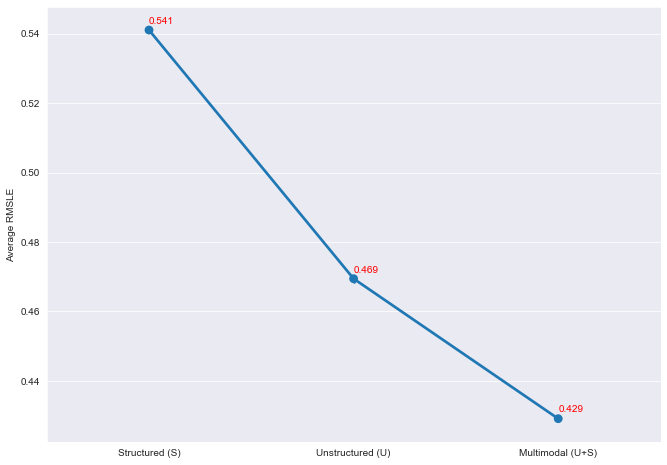

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(11, 8))
g = sns.pointplot(x='', y='RMSLE', data=df, ax=ax, estimator=np.mean)
ax.set_ylabel('Average RMSLE')
[ax.text(p[0], p[1]+0.002, p[1], color='r') for p in zip(ax.get_xticks(), means)]

if save:
  fig.savefig(args.figdir/'rmsle_pointplot.pdf', dpi=300, bbox_inches='tight', pad_inches=0)

## Box Plot

In [ ]:
plot_dfs = []

In [ ]:
prefix,cohort = 'full_common_vital','Notes & Vitals (U+S)'

bams = pickle.load(open(workdir/f'{prefix}_bams.pkl', 'rb'))
final_metrics = pd.read_csv(workdir/f'{prefix}_metrics.csv', index_col=0)
best_models = pd.read_csv(workdir/f'{prefix}_best_models.csv', index_col=0)
ttests = pd.read_csv(workdir/f'{prefix}_ttests.csv', index_col=0)

for k in bams.keys():
  bams[k.upper()] = bams.pop(k)

bams['AVG-ALL'] = bams.pop('AVG-LR-RF-GBM')
bams['MAX-ALL'] = bams.pop('MAX-LR-RF-GBM')

itr = iter(bams.keys())
bams.keys()

metrics = {}

for md in itr:
  df = pd.DataFrame()
  for k, m in bams[md].yield_metrics():
    df[k] = m
  df['Model'] = md
  cols = list(df.columns)
  cols = [cols[-1]] + cols[:-1]
  df = df[cols]
  metrics[md] = df

plot_df = pd.concat(metrics.values())
plot_df['Cohort'] = cohort
plot_dfs.append(plot_df)

In [ ]:
plot_df = pd.concat(plot_dfs)
plot_df[['Sensitivity', 'Specificity', 'PPV', 'AUC']] = plot_df[['Sensitivity', 'Specificity', 'PPV', 'AUC']] * 100
plot_df.shape

In [ ]:
met = 'Sensitivity'

fig, ax = plt.subplots(1,1,figsize=(20,10))
sns.boxplot(x='Model', y=met, hue='Cohort', data=plot_df, ax=ax)
# for i in range(10): plt.axvline(x=i+0.5, ls='-.', color='black')
ax.set_xlabel('')

In [ ]:
save = True
if save:
  fig.savefig(figdir/f'nxv_{met.lower()}_box_plot.pdf', dpi=300)

## Mean AUC

In [ ]:
def get_mean_tprs(bams, base_fpr):
  mean_tprs = {}  
  for model, bam in bams.items():
    tprs = []  
    for i, (targs, probs) in enumerate(zip(bam.targs, bam.pos_probs)):
      fpr, tpr, _ = roc_curve(targs, probs)
      tpr = interp(base_fpr, fpr, tpr)
      tpr[0] = 0.0
      tprs.append(tpr)

    tprs = np.array(tprs)
    mean_tprs[model] = tprs.mean(axis=0)
    
  return mean_tprs

In [ ]:
save = True

In [ ]:
prefix = 'full_common_all'

bams = pickle.load(open(workdir/f'{prefix}_bams.pkl', 'rb'))
final_metrics = pd.read_csv(workdir/f'{prefix}_metrics.csv', index_col=0)
best_models = pd.read_csv(workdir/f'{prefix}_best_models.csv', index_col=0)
ttests = pd.read_csv(workdir/f'{prefix}_ttests.csv', index_col=0)

for k in bams.keys():
  bams[k.upper()] = bams.pop(k)

bams['AVG-ALL'] = bams.pop('AVG-LR-RF-GBM')
bams['MAX-ALL'] = bams.pop('MAX-LR-RF-GBM')

In [ ]:
des = 'all_'

if not des:
  plot_bams = {k: bams[k] for k in bams.keys() if '-' not in k}
  des = ''  
  names = plot_bams.keys()
  aucs = [model.auroc_avg() for _, model in plot_bams.items()]
  legends = [f'{model} ({auc})' for model, auc in zip(names, aucs)]
elif des == 'avg_':
  plot_bams = {k: bams[k] for k in bams.keys() if 'avg' in k}
  names = [name[4:] for name in plot_bams.keys()]
  aucs = [model.auroc_avg() for _, model in plot_bams.items()]
  legends = [f'{model} ({auc})' for model, auc in zip(names, aucs)]  
elif des == 'max_':
  plot_bams = {k: bams[k] for k in bams.keys() if 'max' in k}
  names = [name[4:] for name in plot_bams.keys()]
  aucs = [model.auroc_avg() for _, model in plot_bams.items()]
  legends = [f'{model} ({auc})' for model, auc in zip(names, aucs)]  
elif des == 'all_':
  plot_bams = bams
  names = plot_bams.keys()
  aucs = [model.auroc_avg() for _, model in plot_bams.items()]
  legends = [f'{model} ({auc})' for model, auc in zip(names, aucs)]
  
legends  

In [ ]:
base_fpr = np.linspace(0, 1, 100)
mean_tprs = get_mean_tprs(plot_bams, base_fpr)

fig, ax = plt.subplots(1, 1, figsize=(11, 8))
for i, (model, mean_tpr) in enumerate(mean_tprs.items()):
  ax.plot(base_fpr, mean_tpr)
ax.plot([0, 1], [0, 1], linestyle=':')  
ax.grid(b=True, which='major', color='#d3d3d3', linewidth=1.0)
ax.grid(b=True, which='minor', color='#d3d3d3', linewidth=0.5)
ax.set_ylabel('Sensitivity')
ax.set_xlabel('1 - Specificity')
ax.legend(legends)

if save:
  fig.savefig(figdir/f'{prefix}_{des}mean_auc.pdf', dpi=300)